# Predicting House Prices

Exploring a bit of machine learning, predicting house prices in Ames, Iowa. The data are from 2006 to 2010.

In [1]:
# Bring in libraries and classes from sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

First things first, I'm going to bring in the data and define a few functions. Specifically, there will be three functions:

(1) transform_features()

(2) select_features()

(3) train_and_test()

For now all these functions are going to do is return the training dataset, return the living area and sale price columns from the training dataset, and splits the dataset into train and test, respectively.

I'll embellish these functions a little bit later.

In [83]:
data = pd.read_csv("Train.csv")
data['log_SP'] = np.log(data['SalePrice'])
test = pd.read_csv("Test.csv")

def transform_features(df):
    # Missing value cleaning --------------------------------------
    # Drop these colums that aren't at all useful
    drop_cols = ['PoolArea',
                 'MiscFeature']
    for col in drop_cols:
        df = df.drop(col, axis=1)
    
    # Here are some columns where the missing values are meaningful
    # Turn the NAs into something
    df['Fence'] = df['Fence'].fillna("No Fence")
    df['Alley'] = df['Alley'].fillna('No Alley Access')
    df['LotFrontage'] = df['LotFrontage'].fillna(0)
    garage_cols = ['GarageCond', 'GarageFinish', 'GarageYrBlt',
              'GarageQual', 'GarageType', 'GarageArea']
    for col in garage_cols:
        df[col] = df[col].fillna('No Garage')
    
    # Numeric columns that have less than 5% missing data, replace
    # na with 0
    num_cols = ['BsmtHalfBath', 'BsmtFullBath', 'GarageCars',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF', 'MasVnrArea', 'PoolQC', 'FireplaceQu']
    for col in num_cols:
        df[col] = df[col].fillna(0)
        
    # Some categorical columns about the basement and veneer can
    # have nas be "None"
    cat_cols = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 
               'BsmtFinType1', 'BsmtCond', 'MasVnrType']
    for col in cat_cols:
        df[col] = df[col].fillna('No')
        
    # One missing value on eletrical. replace with most common
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    
    # Dummy code some of the categorical features
    dum = ['MSSubClass', 'MSZoning',
            'LandContour', 'LotConfig', 'Neighborhood',
            'Condition1', 'Condition2', 'BldgType', 
            'HouseStyle', 'RoofStyle', 'RoofMatl', 
            'Exterior1st', 'Exterior2nd', 'MasVnrType', 
            'Foundation', 'Heating', 'CentralAir', 'GarageType',
            'SaleType', 'SaleCondition']
    for col in dum:
        dumdum = pd.get_dummies(df[col], prefix=col, dtype='int')
        df = pd.concat([df, dumdum], axis=1)
        
    # drop all the original categorical columns we dummied
    dumdrop = ['MSSubClass', 'MSZoning',
            'LandContour', 'LotConfig', 'Neighborhood',
            'Condition1', 'Condition2', 'BldgType', 
            'HouseStyle', 'RoofStyle', 'RoofMatl', 
            'Exterior1st', 'Exterior2nd', 'MasVnrType', 
            'Foundation', 'Heating', 'CentralAir', 'GarageType',
            'SaleType', 'SaleCondition']
    for col in dumdrop:
        df = df.drop(col, axis=1)
    
    # Feature Engineering ------------------------------------------
    df['years_until_remod'] = df['YearRemodAdd'] - df['YearBuilt']
    # Adding total sqfootage feature 
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # Let's get one some one hot encoding action. Categorical features that are meaningfully ordinal
    df = df.replace({"Alley" : {"No Alley Access" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No Garage" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No Garage" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )
    
    return df

def select_features(df):
    # Let's select all the numeric features that have a high corr
    # w/ SalePrice (high being over .20)
    num_cols = df.select_dtypes(include = ['int64', 'float64', "uint8"])
    corr = num_cols.corr()
    saleprice_cors = pd.DataFrame(abs(corr['log_SP']))
    sp_over_20 = saleprice_cors[saleprice_cors['log_SP'] > .10]
    high_cor_cols = list(sp_over_20.index)
    df = df[high_cor_cols]
    
    return df

def train_and_test(df, k=0):  
    # Set our iteration parameter and empty list for RMSEs
    rmses = []
    
    # You can use `pd.DataFrame.select_dtypes()` to specify column types
    # and return only those columns as a data frame.
    if k == 0:
        train = df[:730]
        test = df[730:]
    
        numeric_train = train.select_dtypes(include=['integer', 'float'])
        numeric_test = test.select_dtypes(include=['integer', 'float'])
    
        # You can use `pd.Series.drop()` to drop a value.
        features = numeric_train.columns.drop(["SalePrice", "log_SP"])
        lr = linear_model.LinearRegression()
        lr.fit(train[features], train["log_SP"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["log_SP"], predictions)
        rmse = np.sqrt(mse)
        rmses.append(rmse)
        
        return np.mean(rmses)
    
    if k ==1:
        np.random.seed(5150)
        df = df.reindex(np.random.permutation(df.index))
        
        fold_one = df[:730]
        fold_two = df[730:]
        
        numeric_fold_one = fold_one.select_dtypes(include=['integer', 'float'])
        numeric_fold_two = fold_two.select_dtypes(include=['integer', 'float'])
    
        # train 1 test 2
        features = numeric_fold_one.columns.drop(["SalePrice", "log_SP"])
        lr = linear_model.LinearRegression()
        lr.fit(fold_one[features], fold_one["log_SP"])
        predictions = lr.predict(fold_two[features])
        mse = mean_squared_error(fold_two["log_SP"], predictions)
        rmse = np.sqrt(mse)
        rmses.append(rmse)
        
        # train 2 test 1
        features = numeric_fold_two.columns.drop(["SalePrice", "log_SP"])
        lr = linear_model.LinearRegression()
        lr.fit(fold_two[features], fold_two["log_SP"])
        predictions = lr.predict(fold_one[features])
        mse = mean_squared_error(fold_one["log_SP"], predictions)
        rmse = np.sqrt(mse)
        rmses.append(rmse)   
        
        return np.mean(rmses)
    else:
        np.random.seed(5150)
        numeric_df = df.select_dtypes(include=['integer', 'float'])
        features = numeric_df.columns.drop(['SalePrice', 'log_SP'])
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr = linear_model.LinearRegression()
            lr.fit(train[features], train["log_SP"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["log_SP"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        #print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
        
    return np.mean(rmses)

transform_df = transform_features(data)
transform_test = transform_features(test)
filtered_df = select_features(transform_df)

model = train_and_test(filtered_df, k=15)

In [84]:
# This is just the simple linear regression model
model

0.13708401238473727

In [85]:
final_train = filtered_df.drop(['SalePrice', 'GarageArea', 'log_SP'], axis=1)
y = filtered_df['SalePrice']

# Cross Validation with xgboost
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=final_train,label=y)
params = {"objective": 'reg:linear',
          "booster": 'gbtree',
          "colsample_bytree": 0.3,
          "learning_rate": 0.1,
          "max_depth": 8, 
          "alpha": 10, 
          "n_estimators": 30}

xg_reg = xgb.train(dtrain=data_dmatrix,
                    params=params,
                    num_boost_round=500)


[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, ma

[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[09:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nod

[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned no

[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[09:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned no

In [94]:
# Get the predictions for my test data
final_test = transform_test[final_train.columns]

final_test = xgb.DMatrix(final_test)
xgb_pred_prices = xg_reg.predict(final_test)

# Make my submission for Kaggle
my_submission = pd.DataFrame({'ID': test.Id, 'SalePrice': xgb_pred_prices})

#my_submission.to_csv('xgboost_10000_iter_submission.csv',index=False)

In [100]:
d = xgb.DMatrix(final_train)
tester = xg_reg.predict(data_dmatrix)

print(rmsle(y, tester))

153.41726380164678


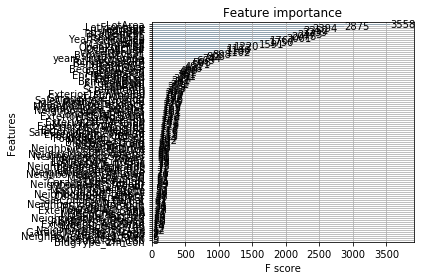

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = xgb.plot_importance(xg_reg)
plt.tight_layout()
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

Not Great, not the best. RMSE of .15261 on the public leaderboard; about the same rank as the Google Comp. Next up will be to work on some proper feature selection and engineering to try and beef this up.

# LightGBM

Training until validation scores don't improve for 20 rounds.
[10]	training's rmse: 22141.3
[20]	training's rmse: 17414.6
[30]	training's rmse: 14911.5
[40]	training's rmse: 12940.9
[50]	training's rmse: 11555.9
[60]	training's rmse: 10342.3
[70]	training's rmse: 9223.73
[80]	training's rmse: 8304.6
[90]	training's rmse: 7664.91
[100]	training's rmse: 6940.89
[110]	training's rmse: 6388.52
[120]	training's rmse: 5836.7
[130]	training's rmse: 5403.39
[140]	training's rmse: 4886.24
[150]	training's rmse: 4494.92
[160]	training's rmse: 4224.8
[170]	training's rmse: 3843.04
[180]	training's rmse: 3457.63
[190]	training's rmse: 3107.92
[200]	training's rmse: 2849.24
[210]	training's rmse: 2635.76
[220]	training's rmse: 2426.21
[230]	training's rmse: 2139.44
[240]	training's rmse: 1913.73
[250]	training's rmse: 1740.04
[260]	training's rmse: 1582.02
[270]	training's rmse: 1413.21
[280]	training's rmse: 1288.99
[290]	training's rmse: 1198.65
[300]	training's rmse: 1114.99
[310]	training's rms

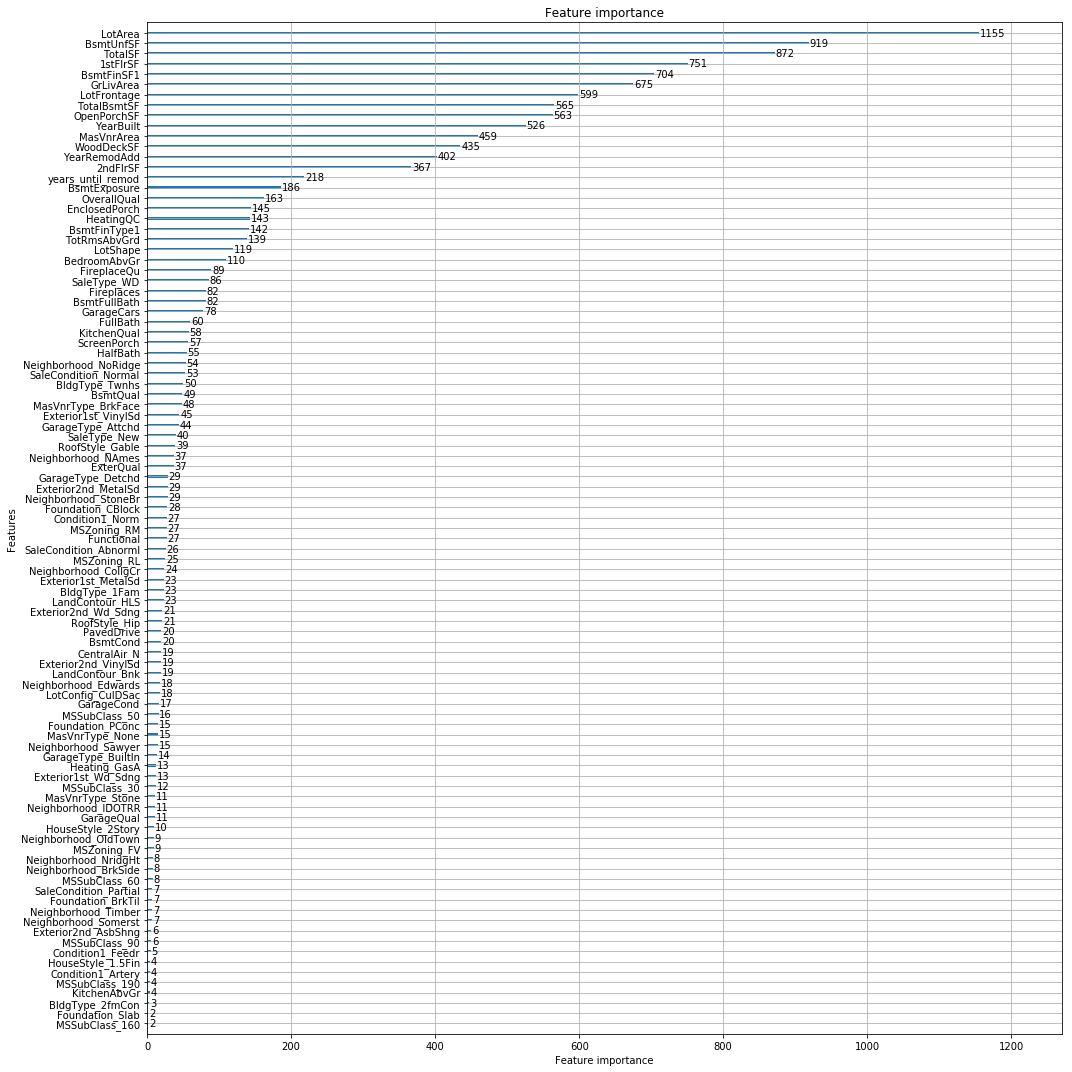

In [110]:
import lightgbm as lgb

params2 = {
    'learning_rate': 0.25,
    'boost': 'gbrt',
    'application': 'root_mean_squared_error',
    'max_depth': 10,
    'num_leaves': 256,
    'verbosity': -1,
    'metric': 'RMSE'
}


d_train = lgb.Dataset(final_train, label=y)
watchlist = [d_train]

model = lgb.train(params2,
                  train_set=d_train,
                  num_boost_round=500,
                  valid_sets=watchlist,
                  early_stopping_rounds=20,
                  verbose_eval=10) 


ax = lgb.plot_importance(model)
plt.tight_layout()
plt.show()

In [102]:
# Get the predictions for my test data
final_test = transform_test[final_train.columns]

lgb_pred_prices = model.predict(final_test)

# Make my submission for Kaggle
my_submission = pd.DataFrame({'ID': test.Id, 'SalePrice': lgb_pred_prices})

#my_submission.to_csv('lgb_10000_iter_submission.csv',index=False)

Light GBM doesn't seem to perform as well. What happens if we stack them?

# Stacking models: xgboost and lightgbm

I'm working from a fantastic kernel by @serigne that can be found here: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard?scriptVersionId=1955054

He did some really fantastic work teaching how to stack models. I've used some of his code below for the AveragingModels class as well as the few rmsle functions defined. Using his tutorial, I've stacked an xgboost and lightgbm model to make a massive improvement on the leaderboards; I jumped 500 spots up the leaderboard by creating this ensemble.

In [88]:
# Define a custom class for averaging the models

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [113]:
# Make our two models; only using xgboost and the other using lightgbm

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(final_train)
    rmse= np.sqrt(-cross_val_score(model, final_train, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Get the rmse scores for each model and the average
averaged_models = AveragingModels(models = (model_xgb, model_lgb))
score1 = rmsle_cv(model_xgb)
score2 = rmsle_cv(model_lgb)
score3 = rmsle_cv(averaged_models)

print(" Averaged xgb models score: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print(" Averaged lgb models score: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))
print(" Averaged models score: {:.4f} ({:.4f})\n".format(score3.mean(), score3.std()))

 Averaged xgb models score: 25143.3060 (3308.4704)

 Averaged lgb models score: 26631.7448 (3838.9056)

 Averaged models score: 25360.6443 (3480.2393)



In [92]:
# Define a function to get the rmse of the stacked model
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Fit our averaged xgb and lgb model, generate predictions, print the training rmse
averaged_models.fit(final_train, y)
stacked_train_pred = averaged_models.predict(final_train)
stacked_pred = averaged_models.predict(final_test)
print(rmsle(y, stacked_train_pred))

8637.616498173576


Now, there are three sets of predictions. One for each of the xgb and lgb models, and then another set for the stacked models. You'll notice from above that the best predictions seemed to come from the stacked model. So here, I'm going to just create an "ensemble" that is just a weighted sum of the three predictions. The most weight being given to the best model, the least weight to the other two (equal because the models performed pretty equally).

With these new features, lgb doesn't seem to be performing as well. Let's try re-weighting these to take some emphasis off lgb.

In [114]:
ensemble = stacked_pred*0.70 + xgb_pred_prices*0.15 + lgb_pred_prices*0.15

# Make my submission for Kaggle - some crazy ass stacked model
my_submission = pd.DataFrame({'ID': test.Id, 'SalePrice': ensemble})

my_submission.to_csv('ensemble_feateng_submission.csv',index=False)

As of today, Sept 20th 2018, this model landed me in the top 45% of this competition. There is much more to be done to improve, but it's also more in the land of feature engineering. I've managed to get this far with almost no feature engineering, and minimal systematic feature selection.